This notebook has to run in an environment with SAM, on Windows it will require WSL.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tifffile import imread
from skimage.color import gray2rgb
from skimage.draw import polygon
import pickle as pkl
import dask.array as da
from tqdm.notebook import tqdm

from sam2.build_sam import build_sam2
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

from utils import smart_path, tile_image
from config import load_config

import torch
torch.cuda.is_available()

True

## Specify configuration

In [2]:
config_file_name = "A01_config.json"

In [4]:
# read in config file

config = load_config(config_file_name)

im_path = smart_path(config.paths.im_path)
analysis_dir = smart_path(config.paths.analysis_dir)

exclude_name = config.paths.exclude_file_suffix

axons_res = config.data_properties.axons_res

sam2_checkpoint = config.sam_model.sam2_checkpoint
model_cfg = config.sam_model.model_cfg

In [5]:
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

device = torch.device("cuda")

torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

## Display image for segmentation

In [7]:
store = imread(im_path, aszarr=True)
im_org = da.from_zarr(store, axons_res).compute()
im_org.shape

(3192, 4010)

In [9]:
# load polygons of annotated regions
annotation_file_path = os.path.join(analysis_dir, f'{exclude_name}.pkl')

with open(annotation_file_path, 'rb') as f:
    annotations = pkl.load(f)

# draw the polygons
for poly in annotations:
    rr, cc = polygon(poly[:, 0], poly[:, 1], im_org.shape)
    im_org[rr, cc] = 0

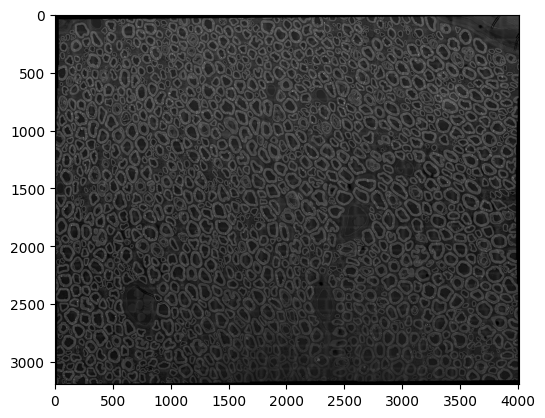

In [10]:
plt.imshow(gray2rgb(im_org))

## Segment axons

In [16]:
# build the model
sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator_2 = SAM2AutomaticMaskGenerator(
    model = sam2,
    points_per_side = config.axons_segmentation.points_per_side,
    points_per_batch = config.axons_segmentation.points_per_batch,
    pred_iou_thresh = config.axons_segmentation.pred_iou_thresh,
    stability_score_thresh = config.axons_segmentation.stability_score_thresh,
    stability_score_offset = config.axons_segmentation.stability_score_offset,
    crop_n_layers = config.axons_segmentation.crop_n_layers,
    box_nms_thresh = config.axons_segmentation.box_nms_thresh,
    crop_n_points_downscale_factor = config.axons_segmentation.crop_n_points_downscale_factor,
    min_mask_region_area = config.axons_segmentation.min_mask_region_area,
    use_m2m = config.axons_segmentation.use_m2m
)

In [ ]:
tile_size_x = config.axons_segmentation.tile_size_x
tile_size_y = config.axons_segmentation.tile_size_y
tile_overlap_x = config.axons_segmentation.tile_overlap_x
tile_overlap_y = config.axons_segmentation.tile_overlap_y
min_area = config.axons_filters.min_area
max_area = config.axons_filters.max_area

# tile the image
tiles, coords = tile_image(im_org, tile_size_x, tile_size_y, tile_overlap_x, tile_overlap_y)

for tile,coord in tqdm(zip(tiles, coords), total=len(tiles)):

    if np.max(tile) == 0:
        continue    

    masks = mask_generator_2.generate(gray2rgb(tile))

    df = pd.DataFrame(masks)
    df = df[((df['area'] > min_area) & (df['area'] < max_area))]

    df['tile_row_start'] = coord[1]
    df['tile_row_end'] = coord[3]
    df['tile_col_start'] = coord[0]
    df['tile_col_end'] = coord[2]

    # save the masks
    file_name = f"tile_masks_{str(coord[1]).zfill(5)}_{str(coord[0]).zfill(5)}.pkl"
    df.to_pickle(os.path.join(analysis_dir, file_name))

  0%|          | 0/30 [00:00<?, ?it/s]/home/kasia/sam/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/kasia/sam/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  masks = self._transforms.postprocess_masks(
  3%|▎         | 1/30 [00:26<12:34, 26.03s/it]/home/kasia/sam/sam2/sam2/sam2_image_predictor.py:431: UserWarning: cannot import name '_C' from 'sam2' (/home/kasia/sam/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main